# Deep Q-learning
## Zein Alabedeen Barhoum

In this notebook, three implementation of deep Q-learning reinforcement learning where applied. 

1. Simple deep Q-learning
2. Q-learning with experience reply
3. Q-learning with experience reply and target network
   
The environment used for testing is `CartPole-v0` from `gym` library

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython import display
from pyvirtualdisplay import Display
d = Display(visible=0, size=(400, 300))
d.start()

def show_state(env, episode=0, step=0, info=""):
    plt.figure(3)
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("%s | Eposide: %d | Step: %d %s" % ('Cart-pole-v1', episode, step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())


In [ ]:
import copy
import torch
from torch.autograd import Variable
import random
import math
import torchvision.transforms as T
import numpy as np
import time

# Task 1: Simple DQN


In [ ]:

class DQN():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=12, alpha=0.001):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(hidden_dim, action_dim),
            )
            self.optimizer = torch.optim.Adam(self.model.parameters(), alpha)
            self.schedular = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size= 50, gamma= 0.95)
            self.losses = []

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))

        self.losses.append(loss.detach().numpy())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))

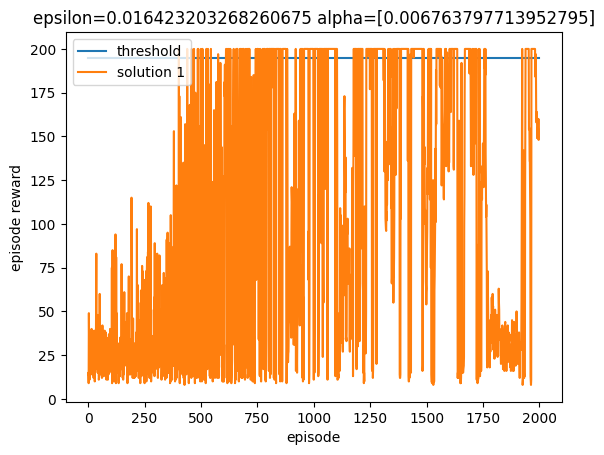

done


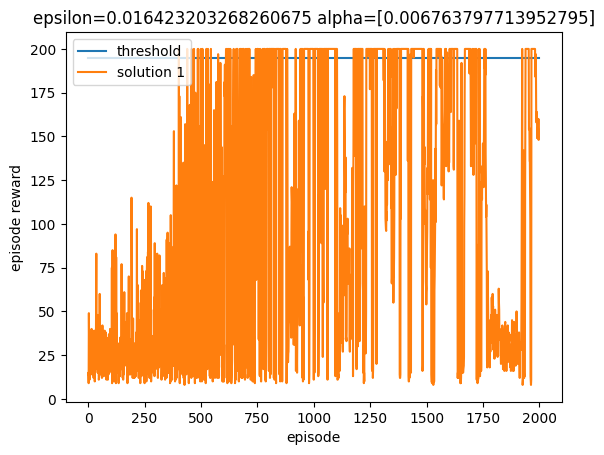

In [ ]:
import gym, math
import numpy as np

env = gym.make('CartPole-v0')

# Q table
n_states = 4
n_actions = env.action_space.n # Actions

# Learning Parameters
epsilon = 1 # gready threashold
alpha = 0.05 # learning rate
gamma = 0.99 # reward discount factor

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 2000
STEPS_MAX = 200
DESIRED_STEPS = 200

# Loggers
log_total_reward = np.zeros(EPISODES_MAX)
log_steps_number = np.zeros(EPISODES_MAX)

#
n_hidden = 16
model = DQN(n_states, n_actions, n_hidden, alpha)

# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    rewards = 0
    state = observation

    if i_episode > 50 and (i_episode + 1) %50  == 0 and epsilon > 0.01:
        epsilon = epsilon*0.9
    if i_episode > 50 and (i_episode + 1) % 50 == 0:
        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={} alpha={}'.format(epsilon, model.schedular.get_last_lr()))
        display.clear_output(wait=True)
        display.display(plt.gcf())

    for t in range(STEPS_MAX):
        q_values = model.predict(state)

        if np.random.random_sample() < epsilon:
            action = env.action_space.sample()
        else:
            action = torch.argmax(q_values).item()

        observation, reward, done, info = env.step(action)

        rewards += reward
        next_state = observation

        q_values_list = q_values.tolist()

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t
            # your code here
            q_values[action] = reward
            model.update(state, q_values)
            # print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            break

        # Update Q-network
        q_values_next = model.predict(next_state)
        q_values[action] = reward+ gamma*torch.max(q_values_next).item()
        model.update(state, q_values)

        # Update current state
        state = next_state

    model.schedular.step()

print("done")

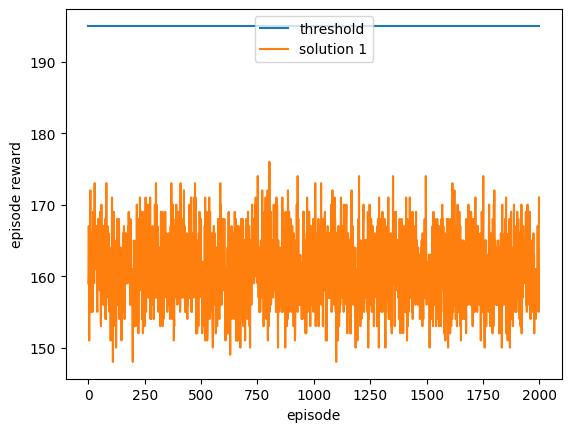

done


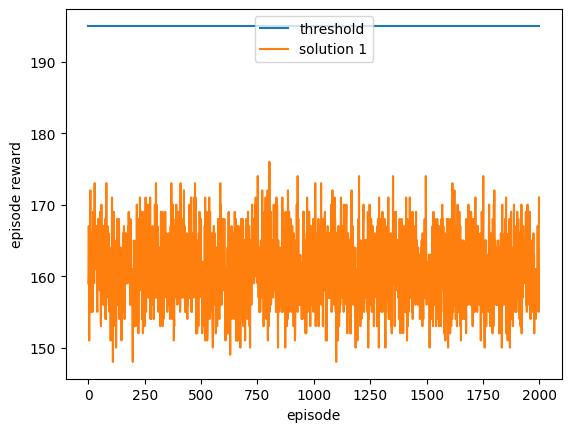

In [ ]:
# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    rewards = 0
    state = observation

    if i_episode > 50 and (i_episode + 1) % 50 == 0:
        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 1")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        display.clear_output(wait=True)
        display.display(plt.gcf())

    for t in range(STEPS_MAX):
        q_values = model.predict(state)
        action = torch.argmax(q_values).item()
        observation, reward, done, info = env.step(action)

        rewards += reward
        next_state = observation

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t

            break

        # Update current state
        state = next_state


print("done")

# Task 2: DQN with experience replay

In [ ]:
del model

In [ ]:
class DQN_with_replay():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=12, alpha=0.001):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(hidden_dim, action_dim),
            )
            self.optimizer = torch.optim.Adam(self.model.parameters(), alpha)
            self.schedular = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size= 50, gamma= 0.98)
            self.losses = []
            self.memory = []

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))

        self.losses.append(loss.detach().numpy())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))
    def replay(self, size, gamma):
      if(len(self.memory)<size):
        return
      batch = random.sample(self.memory, size)

      batch_t = list(map(list, zip(*batch)))
      states = torch.Tensor(batch_t[0])
      actions = torch.LongTensor(batch_t[1])
      next_states = torch.Tensor(batch_t[2])
      rewards = torch.Tensor(batch_t[3])
      is_done = torch.Tensor(batch_t[4])

      all_q_values = self.predict(states)
      all_q_values_next = self.predict(next_states)

      all_q_values[range(len(all_q_values)), actions] = rewards+(1-is_done)*gamma*torch.max(all_q_values_next, axis= 1).values

      self.update(states.tolist(), all_q_values.tolist())


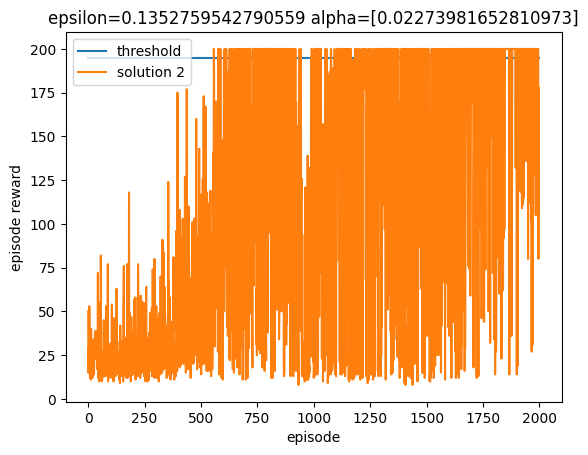

done


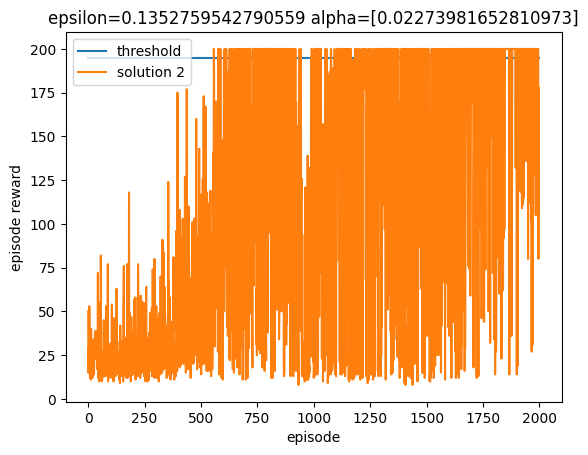

In [ ]:
env = gym.make('CartPole-v0')

# Learning Parameters
epsilon = 1 # gready threashold
alpha = 0.05 # learning rate
gamma = 0.99 # reward discount factor

# Q table
n_states = 4
n_actions = env.action_space.n # Actions

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 2000
STEPS_MAX = 200
DESIRED_STEPS = 200

# Loggers
log_total_reward = np.zeros(EPISODES_MAX)
log_steps_number = np.zeros(EPISODES_MAX)

#
n_hidden = 16
model = DQN_with_replay(n_states, n_actions, n_hidden, alpha)

#
replay_size = 10

# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    rewards = 0
    state = observation

    if i_episode > 50 and (i_episode + 1) %50  == 0 and epsilon > 0.01:
        epsilon = epsilon*0.95
    if i_episode > 50 and (i_episode + 1) % 50 == 0:
        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 2")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={} alpha={}'.format(epsilon, model.schedular.get_last_lr()))
        display.clear_output(wait=True)
        display.display(plt.gcf())

    for t in range(STEPS_MAX):
        q_values = model.predict(state)

        if np.random.random_sample() < epsilon:
            action = env.action_space.sample()
        else:
            action = torch.argmax(q_values).item()

        observation, reward, done, info = env.step(action)

        rewards += reward
        next_state = observation
        model.memory.append((state, action, next_state, reward, done))

        q_values_list = q_values.tolist()

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t
            # your code here
            if(len(model.memory)<replay_size):
              q_values[action] = reward
              model.update(state, q_values)
            else:
              model.replay(replay_size, gamma)

            # print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            break

        # Update Q-network
        if(len(model.memory)<replay_size):
          q_values_next = model.predict(next_state)
          q_values[action] = reward+ gamma*torch.max(q_values_next).item()
          model.update(state, q_values)
        else:
          model.replay(replay_size, gamma)

        # Update current state
        state = next_state
    model.schedular.step()


print("done")

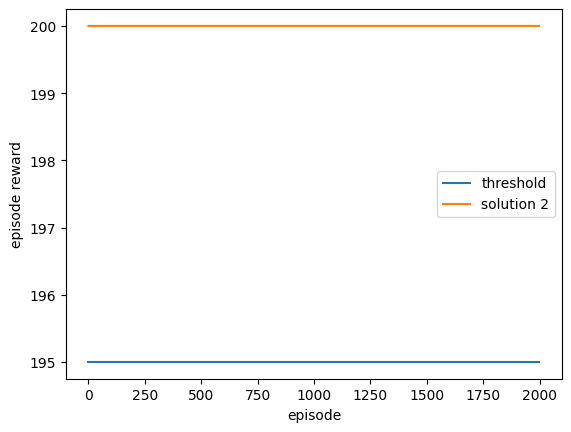

done


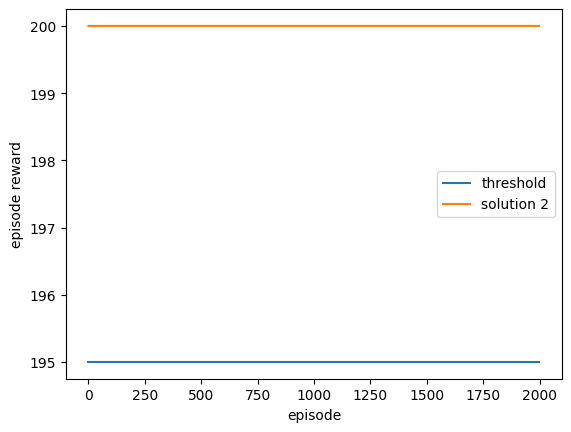

In [ ]:

# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    rewards = 0
    state = observation

    if i_episode > 50 and (i_episode + 1) % 50 == 0:
        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 2")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        display.clear_output(wait=True)
        display.display(plt.gcf())

    for t in range(STEPS_MAX):
        q_values = model.predict(state)
        action = torch.argmax(q_values).item()
        observation, reward, done, info = env.step(action)

        rewards += reward
        next_state = observation

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t

            break

        # Update current state
        state = next_state

print("done")

# Task 3: Adding Target Network

In [ ]:
del model

In [ ]:
import copy

class TQDN():
  def __init__(self, dqn):
    self.model = copy.deepcopy(dqn.model)
    self.dqn = dqn
  def update(self):
    parameters = self.dqn.model.state_dict()
    self.model.load_state_dict(parameters)
  def predict(self, state):
    """ Compute Q values for all actions using the DQL. """
    with torch.no_grad():
        return self.model(torch.Tensor(state))



In [ ]:
class DQN_with_replay_tn():
    ''' Deep Q Neural Network class. '''
    def __init__(self, state_dim, action_dim, hidden_dim=12, alpha=0.001):
            self.criterion = torch.nn.MSELoss()
            self.model = torch.nn.Sequential(
                torch.nn.Linear(state_dim, hidden_dim),
                torch.nn.LeakyReLU(),
                torch.nn.Linear(hidden_dim, action_dim),
            )
            self.optimizer = torch.optim.Adam(self.model.parameters(), alpha)
            self.schedular = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size= 50, gamma= 0.98)
            self.losses = []
            self.memory = []

    def update(self, state, y):
        """Update the weights of the network given a training sample. """
        y_pred = self.model(torch.Tensor(state))
        loss = self.criterion(y_pred, Variable(torch.Tensor(y)))

        self.losses.append(loss.detach().numpy())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, state):
        """ Compute Q values for all actions using the DQL. """
        with torch.no_grad():
            return self.model(torch.Tensor(state))
    def replay(self, tmodel, size, gamma):
      if(len(self.memory)<size):
        return
      batch = random.sample(self.memory, size)

      batch_t = list(map(list, zip(*batch)))
      states = torch.Tensor(batch_t[0])
      actions = torch.LongTensor(batch_t[1])
      next_states = torch.Tensor(batch_t[2])
      rewards = torch.Tensor(batch_t[3])
      is_done = torch.Tensor(batch_t[4])

      all_q_values = tmodel.predict(states)
      all_q_values_next = tmodel.predict(next_states)

      all_q_values[range(len(all_q_values)), actions] = rewards+(1-is_done)*gamma*torch.max(all_q_values_next, axis= 1).values

      self.update(states.tolist(), all_q_values.tolist())


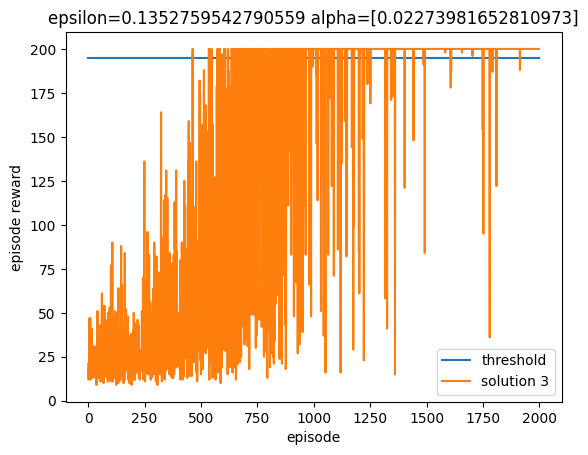

done


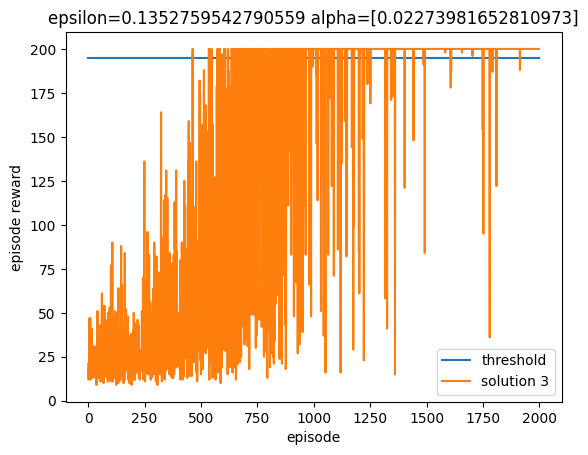

In [ ]:
env = gym.make('CartPole-v0')

# Learning Parameters
alpha = 0.05 # learning rate
epsilon = 1 # gready threashold
gamma = 0.99 # reward discount factor

# Q table
n_states = 4
n_actions = env.action_space.n # Actions

# Execution parameters
SHOW_ANIMATION = False
EPISODES_MAX = 2000
STEPS_MAX = 200
DESIRED_STEPS = 200

# Loggers
log_total_reward = np.zeros(EPISODES_MAX)
log_steps_number = np.zeros(EPISODES_MAX)

#
n_hidden = 16
model = DQN_with_replay_tn(n_states, n_actions, n_hidden, alpha)
tmodel = TQDN(model)
#
replay_size = 10


# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    rewards = 0
    state = observation

    if i_episode > 50 and (i_episode + 1) %50  == 0 and epsilon > 0.01:
        epsilon = epsilon*0.95
    if i_episode > 50 and (i_episode + 1) %10:
        tmodel.update()
    if i_episode > 50 and (i_episode + 1) % 50 == 0:
        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 3")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        plt.title('epsilon={} alpha={}'.format(epsilon, model.schedular.get_last_lr()))
        display.clear_output(wait=True)
        display.display(plt.gcf())

    for t in range(STEPS_MAX):
        q_values = model.predict(state)

        if np.random.random_sample() < epsilon:
            action = env.action_space.sample()
        else:
            action = torch.argmax(q_values).item()

        observation, reward, done, info = env.step(action)

        rewards += reward
        next_state = observation
        model.memory.append((state, action, next_state, reward, done))

        q_values_list = q_values.tolist()

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t
            # your code here
            if(len(model.memory)<replay_size):
              q_values[action] = reward
              model.update(state, q_values)
            else:
              model.replay(tmodel, replay_size, gamma)

            # print('Episode finished after {} timesteps, total rewards {}'.format(t+1, rewards))
            break

        # Update Q-network
        if(len(model.memory)<replay_size):
          q_values_next = model.predict(next_state)
          q_values[action] = reward+ gamma*torch.max(q_values_next).item()
          model.update(state, q_values)
        else:
          model.replay(tmodel,replay_size, gamma)

        # Update current state
        state = next_state
    model.schedular.step()

    # plt.figure(1)
    # plt.clf()
    # plt.plot(range(0,len(model.losses)), model.losses, label="loss")
    # plt.xlabel('step')
    # plt.ylabel('loss')
    # display.clear_output(wait=True)
    # display.display(plt.gcf())


print("done")

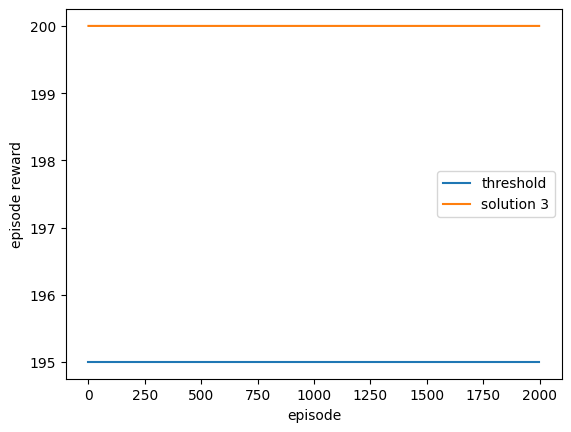

done


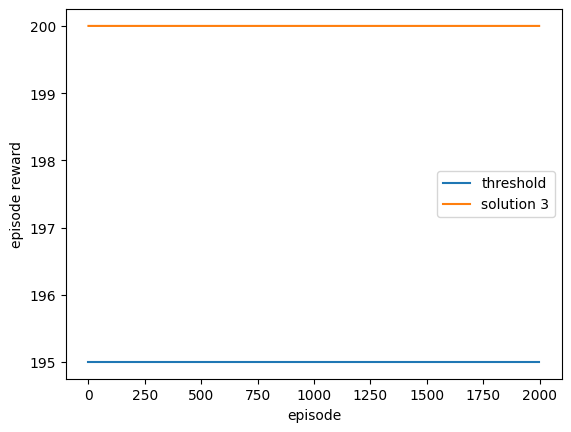

In [ ]:
# Q-learning
for i_episode in range(EPISODES_MAX):
    observation = env.reset()
    rewards = 0
    state = observation

    if i_episode > 50 and (i_episode + 1) % 50 == 0:
        plt.figure(2)
        plt.clf()
        plt.plot([0,i_episode], [195, 195], label="threshold")
        plt.plot(range(0,i_episode), log_total_reward[0:i_episode], label="solution 3")
        plt.xlabel('episode')
        plt.ylabel('episode reward')
        plt.legend()
        display.clear_output(wait=True)
        display.display(plt.gcf())

    for t in range(STEPS_MAX):
        q_values = model.predict(state)
        action = torch.argmax(q_values).item()
        observation, reward, done, info = env.step(action)

        rewards += reward
        next_state = observation

        if done:
            log_total_reward[i_episode] = rewards
            log_steps_number[i_episode] = t

            break

        # Update current state
        state = next_state
    # plt.figure(1)
    # plt.clf()
    # plt.plot(range(0,len(model.losses)), model.losses, label="loss")
    # plt.xlabel('step')
    # plt.ylabel('loss')
    # display.clear_output(wait=True)
    # display.display(plt.gcf())


print("done")